In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import kmedoids
import adspy_shared_utilities
from adspy_shared_utilities import plot_labelled_scatter
from adjustText import adjust_text

Load the preprocessed cluster dataframe

In [2]:
cluster_df = pd.read_csv('cluster_df')
cluster_df.columns

Index(['Unnamed: 0', 'year', 'gameid', 'season_id', 'id_x', 'name', 'id_y',
       'game_id', 'team_id', 'player_id', 'position', 'player_name', 'goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves', 'created_at',
       'updated_at'],
      dtype='object')

Create new df filtered on the year represented

In [3]:
#specify the year to use here (2015-2023)
year = 2019

In [4]:
def year_df(year):
   cluster_df = pd.read_csv('cluster_df')
   df = cluster_df[cluster_df['year'] == year]
   pos_df = df[['position', 'goals',
      'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
      'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
      'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
      'goalie_seconds', 'goals_allowed', 'goalie_saves']]
   pos_df_no = pos_df.dropna()

   #print(pos_df.shape, pos_df_no.shape)

   #Create X and y from year1_df for training, sampling, testing, etc.
   X = pos_df_no[['goals',
      'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
      'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
      'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
      'goalie_seconds', 'goals_allowed', 'goalie_saves']]
   y = pos_df_no[['position']]

   return X, y, pos_df_no


In [5]:
X = year_df(year)[0]
y = year_df(year)[1]

In [9]:
X.columns

Index(['goals', 'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves'],
      dtype='object')

Determine the best k value for KMeans evaluation
Use low Davies Bouldin score and high Calinski Harabasz

In [6]:
def best_k(X, year, init):
    davbou = []
    calhar = []
    inertia = []
    kays = range(2,16)  
    for k in kays:
        km = KMeans(n_clusters=k, init=init, max_iter=100, n_init=10, random_state=42)
        km.fit(X)
        davbou.append((k, metrics.davies_bouldin_score(X, km.labels_)))
        calhar.append((k, metrics.calinski_harabasz_score(X, km.labels_)))
        inertia.append(km.inertia_)
    print('davbou= ', sorted(davbou, key=lambda a: a[1]))
    print('calhar= ', sorted(calhar, key=lambda a: a[1], reverse=True))
    print(inertia)
    
    plt.plot(range(2, 16), inertia)
    plt.suptitle('Figure 16: Kmeans Inertia for '+ str(year))
    plt.title(init, fontsize=9)
    plt.xlabel('# of clusters')
    plt.tight_layout()
    plt.grid(True)
    
    fig, ax1 = plt.subplots()
    ax1.plot(range(2, 16), [ch[1] for ch in calhar], color='blue')
    ax1.set_xlabel('# of clusters')    
    ax1.set_ylabel('Calinski Harabasz score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(range(2, 16), [db[1] for db in davbou], color='red')
    ax2.set_ylabel('Davies Bouldin score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.xticks(range(2,16))
    
    plt.suptitle('Figure 17: Where is the highest CH and the lowest BD?', fontsize=10)
    plt.title((year,init), fontsize=9)
    #plt.grid(True)
    fig.tight_layout()
    plt.show()


davbou=  [(2, 0.1293042768503863), (3, 0.30608584924961874), (5, 0.3182278054970104), (6, 0.34006212975529976), (4, 0.3410902861645594), (7, 0.3945150981614104), (9, 0.42015852521111596), (8, 0.4253022665388824), (14, 0.42733497610713794), (15, 0.42803139937571333), (13, 0.446317078056511), (10, 0.45930634761896894), (11, 0.46203309580952256), (12, 0.4764469716032503)]
calhar=  [(15, 5754315.972996883), (14, 5388544.7711799685), (13, 4968700.244218657), (12, 4708158.248730275), (11, 4420867.517298941), (10, 4114613.4290185506), (9, 3914870.5544447405), (8, 3498226.4239252987), (7, 3230463.8470239392), (6, 2959996.642325846), (5, 2549155.917590607), (4, 2283667.7841296843), (3, 1732072.2653175215), (2, 795587.4357181642)]
[1251989586.3998787, 295494017.3977877, 150020675.34739465, 100933098.44400755, 69597451.51024532, 53164681.006923385, 42093295.37910205, 32919098.155684195, 27843920.502722003, 23325677.65372, 19914031.85487446, 17298198.016420174, 14722658.897220898, 12802403.9645428

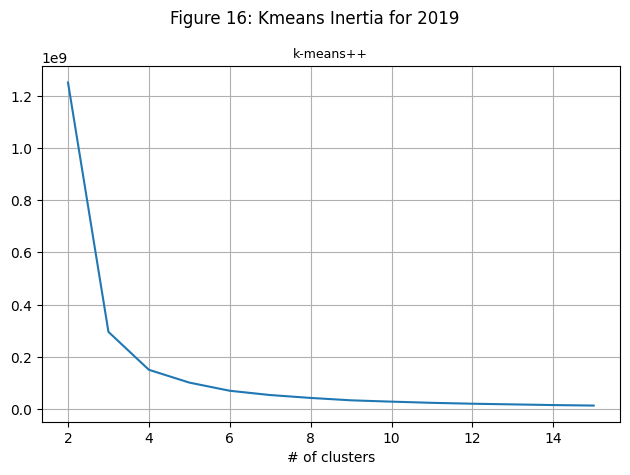

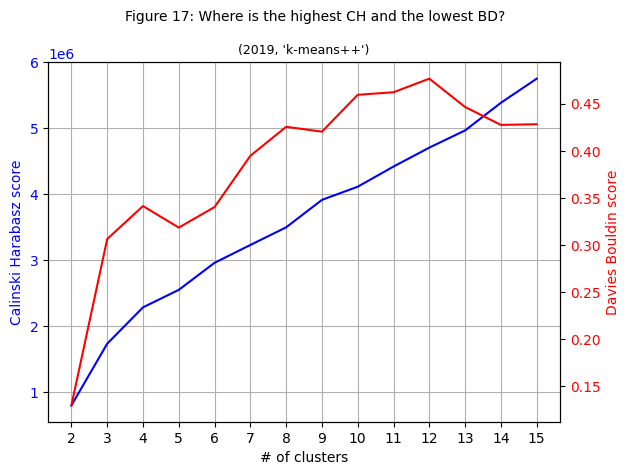

In [7]:
#init either random or k-means++ and entered as a string
best_k(X, year, 'k-means++')

davbou=  [(2, 0.1293042768503863), (3, 0.30575430395309383), (4, 0.4163206219515223), (7, 0.4475812697741411), (5, 0.470753461659802), (8, 0.4763093679179661), (11, 0.5449138738522992), (6, 0.5507546882592987), (10, 0.5934351716966492), (12, 0.6254835424151745), (9, 0.630479318311781), (14, 0.6770101146981627), (15, 0.8682227424133799), (13, 0.871631197845821)]
calhar=  [(14, 2600181.739308801), (7, 2067305.060013661), (15, 2027949.4098151133), (3, 1732065.603214113), (13, 1692125.7037658594), (9, 1690121.776582686), (10, 1641169.8230665086), (4, 1593531.262603265), (12, 1407080.4201194106), (11, 1404915.0131914075), (5, 1294813.1579384375), (6, 1121619.3835547946), (2, 795587.4357181642), (8, 760459.7455746589)]
[1251989586.3998787, 295495146.2703559, 214602802.85804474, 198169016.268461, 183086521.02891165, 83010596.0712824, 192818513.880502, 76159063.6856822, 69736239.89038649, 73296668.03307152, 66541073.845517024, 50743561.56647565, 30497371.66201672, 36305933.92538026]


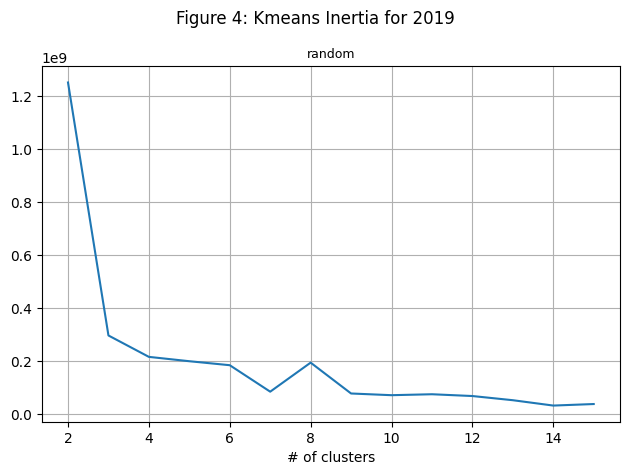

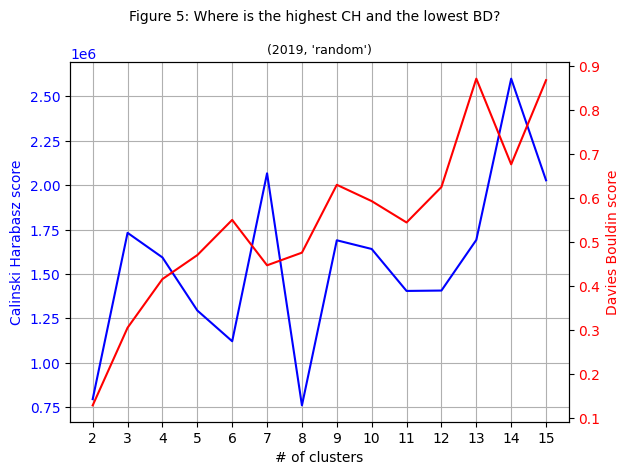

In [7]:
#init either random or k-means++ and entered as a string
best_k(X, year, 'random')

In [8]:
#decide k based on values above
k = 7

Normalize the data for modeling

In [9]:
#X = year_df(year)[0]
def X_norm(X):
    X_norm = StandardScaler().fit_transform(X)
    return X_norm


In [10]:
X_norm = X_norm(X)

In [11]:
def km(X_norm, k):
    kmeans = KMeans(n_clusters=k, init='random', max_iter=100, n_init=10, random_state=42)
    model = kmeans.fit(X_norm)  
    print(model.labels_[:15])
    print(len(model.labels_))
    print(model.n_features_in_)
    return model   

In [12]:
kmeans = km(X_norm,k)

[5 5 3 0 5 0 5 5 3 5 1 5 1 5 4]
28856
17


How does this model plot look?

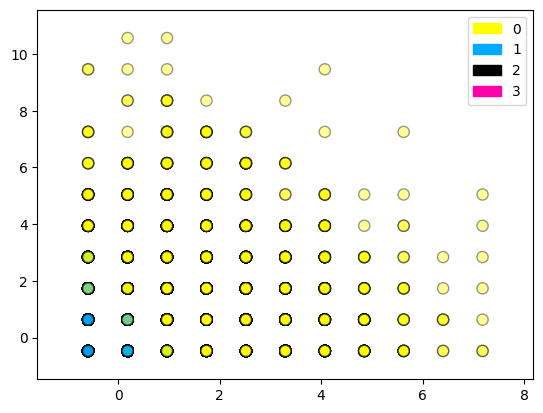

In [113]:
plot_labelled_scatter(X_norm, kmeans.labels_, [0,1,2,3])

In [13]:
kmeans_label = kmeans.predict(X_norm)

Time to try PCA on the dataset before the ML algorithm

In [15]:
def scree_variance(X_norm, n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit_transform(X_norm)
    plt.figure(figsize=(10,6))

    plt.plot(range(1, n_comp+1), pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component', size = 10)
    plt.ylabel('Proportion of Variance Explained', size = 10)
    plt.title('Figure 18: Scree Plot for Proportion of Variance Explained', size = 15)
    plt.grid(True)

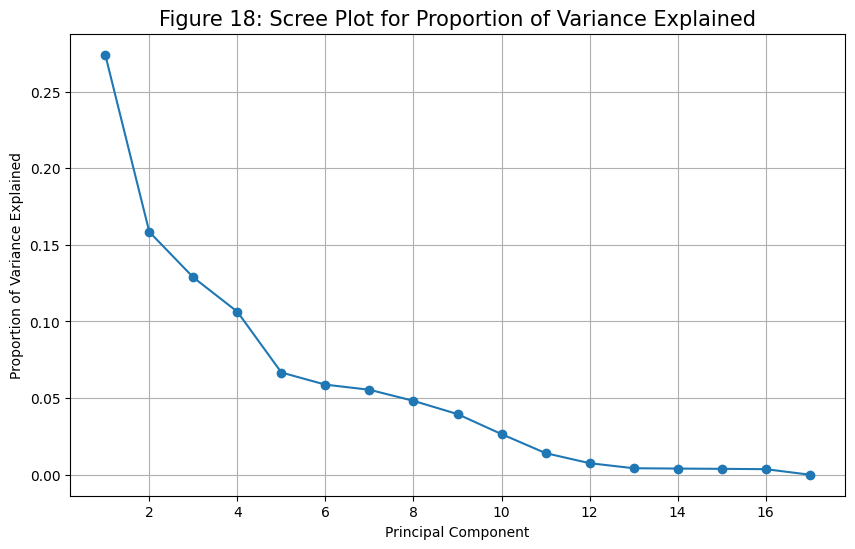

In [16]:
scree_variance(X_norm, 17)

In [30]:
def scree_eigen(X_norm, n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit_transform(X_norm)
    plt.figure(figsize=(10,6))

    plt.plot(range(1, n_comp+1), pca.explained_variance_, marker='o')
    plt.xlabel('Principal Component', size = 10)
    plt.ylabel('Eigenvalue', size = 10)
    plt.title('Figure 6: Scree Plot for Eigenvalues', size = 15)
    plt.axhline(y=1, color='r', linestyle='--')
    plt.grid(True)

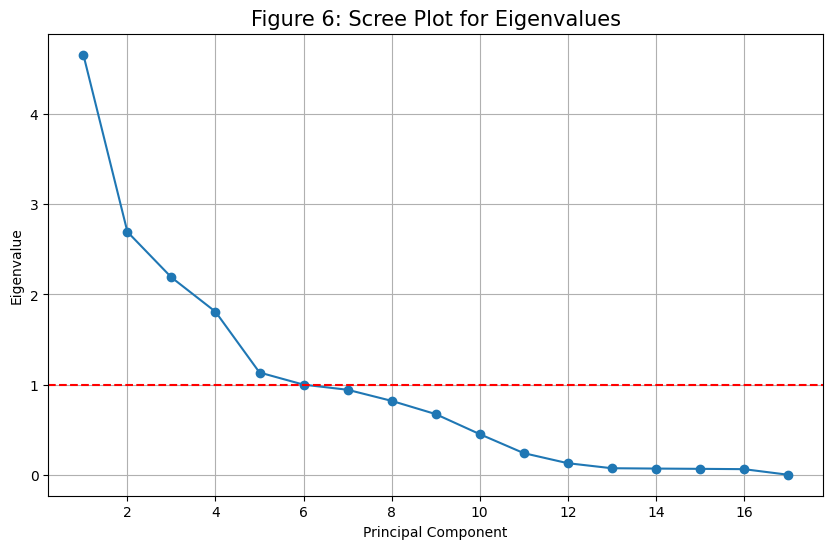

In [31]:
scree_eigen(X_norm,17)

In [12]:
def best_PC(X_norm, n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit_transform(X_norm)
    eigenvals = pca.explained_variance_
    vals = [v for v in eigenvals if v > 1]
    return len(vals)

In [13]:
best_n_comp = best_PC(X_norm, 17)
best_n_comp

5

In [14]:
#trying PCA with the best n_components from above
pca = PCA(n_components=best_n_comp)
Xpca = pca.fit_transform(X_norm)

What does this look like

In [15]:
cols = ['PC'+str(n) for n in range(1, best_n_comp+1)]

Xpca_df = pd.DataFrame(Xpca, columns=cols)
Xpca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.088245,1.332020,-0.363682,-0.399649,-0.866961
1,0.055005,-0.038412,-0.654119,-1.166473,-0.902760
2,0.590953,0.165152,-0.548553,-1.066067,-0.914379
3,4.229209,1.460475,0.123643,-0.471037,-0.937126
4,-0.358950,-0.203610,-0.740435,-1.250968,-0.899108


Fit pca on kmeans

What does a biplot look like

In [16]:
Xkmeans = km(Xpca, best_n_comp)

[3 3 3 1 3 1 3 3 1 3 2 3 1 3 4]
28856
5


In [24]:
#reference site for example and code https://statisticsglobe.com/principal-component-analysis-python
#reference for non overlapping text https://python-graph-gallery.com/web-text-repel-with-matplotlib/
#reference for biplot also SIADS 543 week 1

def biplot(score,coeff,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    shiftx = 1
    shifty = 0.25
    #scalex = 1.0/(xs.max() - xs.min())
    #scaley = 1.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex+.07, ys * scaley+.015, s=5, color = 'lightblue')
    plt.scatter(xs+shiftx, ys+shifty, s=5, color = 'lightblue')

    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*15, coeff[i,1]*15, color = 'red', alpha = 0.5)
        texts.append(plt.text(coeff[i,0]* 15, coeff[i,1] * 15, labels[i], color = 'black', 
                 fontsize = 'small', ha = 'center', va = 'center'))
    adjust_text(texts)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    plt.title('PCA Biplot')
    plt.tight_layout()
    plt.figure()

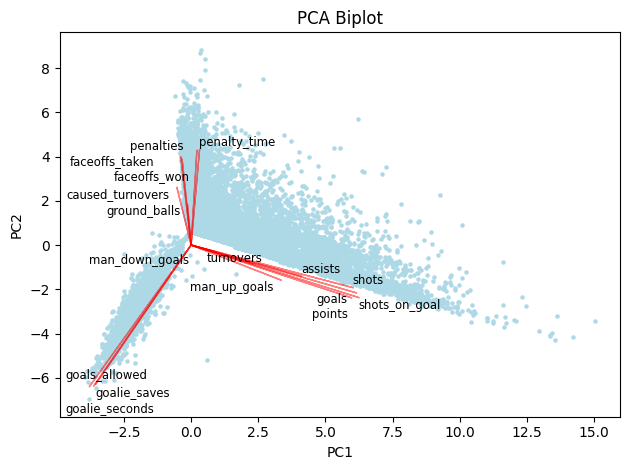

<Figure size 640x480 with 0 Axes>

In [25]:
biplot(Xpca, np.transpose(pca.components_), list(X.columns))

In [25]:
#reference site for example and code https://statisticsglobe.com/principal-component-analysis-python
#reference for non overlapping text https://python-graph-gallery.com/web-text-repel-with-matplotlib/
#reference for biplot also SIADS 543 week 1

def biplot_scatter(data, coeff, year, labels=None):
 
    label = Xkmeans.predict(data)
    unique_labels = np.unique(label)
    shiftx = 1.1
    shifty = 0.2
    for i in unique_labels:
        plt.scatter(data[label==i, 0]+shiftx, data[label==i, 1]+shifty, s=3, label = i)
   
    plt.scatter(Xkmeans.cluster_centers_[:,0]+shiftx, Xkmeans.cluster_centers_[:,1]+shifty, s=10,color='black')
    #plt.title('PCA Scatterplot by Cluster')
    #plt.show()

    n = coeff.shape[0]   
    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0] * 15, coeff[i,1] * 15, color = 'yellow', alpha = 0.5)
        texts.append(plt.text(coeff[i,0]* 15, coeff[i,1] * 15, labels[i], color = 'black', 
                 fontsize = 'small', ha = 'center', va = 'center'))
    adjust_text(texts)
    plt.xlabel('PC{}'.format(1))
    plt.ylabel('PC{}'.format(2))    
    plt.title('Figure 8: PCA Biplot with Scatterplot by Cluster for '+str(year))
    plt.tight_layout()
    plt.figure()

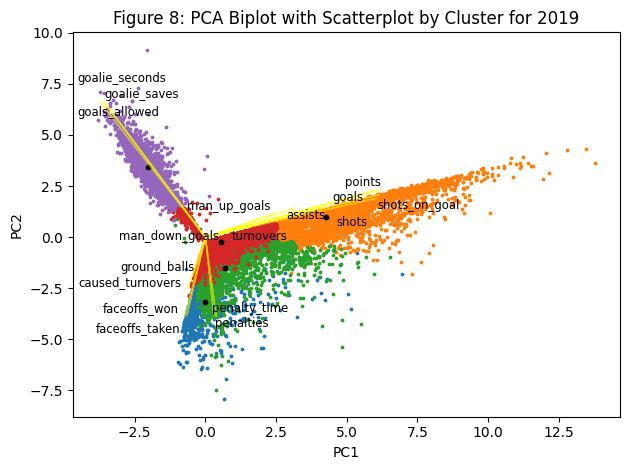

<Figure size 640x480 with 0 Axes>

In [26]:
biplot_scatter(Xpca, np.transpose(pca.components_), year, list(X.columns))

Create a scatter plot of pca

In [127]:
def scatter_pca(data):
    label = Xkmeans.predict(data)
    unique_labels = np.unique(label)
    for i in unique_labels:
        plt.scatter(data[label==i, 0], data[label==i, 1], s=3, label = i)

    
    plt.scatter(Xkmeans.cluster_centers_[:,0], Xkmeans.cluster_centers_[:,1], s=10,color='black')
    plt.title('PCA Scatterplot by Cluster')
    plt.show()

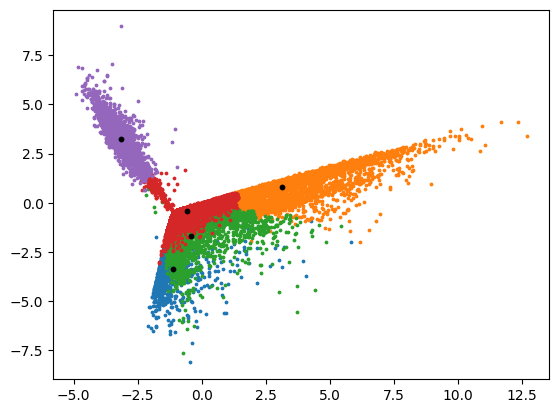

In [128]:
scatter_pca(Xpca)

Aha! This looks a lot better. Time to do an analysis to find the best PCA component value and look at other parameters.

In [53]:
def pcamle(X):
    pcamle = PCA(n_components='mle', random_state=42)
    Xpcamle = pcamle.fit_transform(X)
    labelmle = Xkmeans.fit_predict(Xpcamle)
    unique_labelsmle = np.unique(labelmle)
    for i in unique_labelsmle:
        plt.scatter(Xpcamle[labelmle==i, 0], Xpcamle[labelmle==i, 1], s=10, label = i)
    plt.scatter(Xkmeans.cluster_centers_[:,0], Xkmeans.cluster_centers_[:,1], s=10,color='black')
    plt.title('PCA Scatterplot by cluster using mle')
    plt.show()

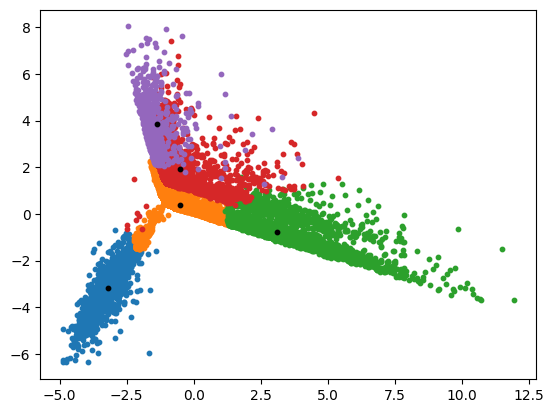

In [54]:
pcamle(X_norm)

Heat map of the features for number of principal components

In [115]:
def heat_map(n_comp, year):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:n_comp+1], interpolation = 'none', cmap = 'plasma')
    feature_names=['goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves']
    lst = []
    for p in range(1, n_comp+1):
        lst.append('PC '+str(p))
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 70, fontsize=12)
    plt.yticks(np.arange(0., n_comp, 1), lst, fontsize = 16)
    plt.title('PCA heat map by PC for '+str(year), loc='left')
    plt.colorbar()

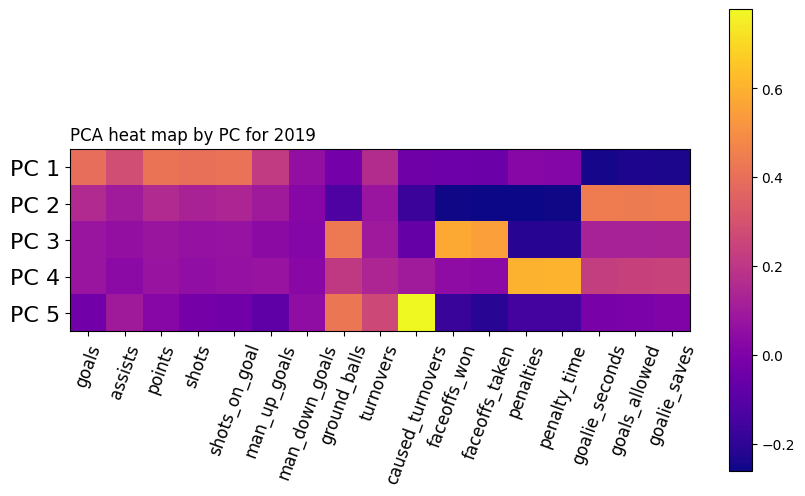

In [116]:
heat_map(best_n_comp, year)

Try sparse pca

In [27]:
def sparse_heat_map(data, n_comp, year):
    pca_sparse = SparsePCA(n_components=n_comp, alpha=15, random_state=42)
    pca_sparse.fit_transform(data)

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca_sparse.components_[0:n_comp+1], interpolation = 'none', cmap = 'plasma')
    lst = []
    for p in range(1, n_comp+1):
        lst.append('PC '+str(p))
    feature_names=['goals',
       'assists', 'points', 'shots', 'shots_on_goal', 'man_up_goals',
       'man_down_goals', 'ground_balls', 'turnovers', 'caused_turnovers',
       'faceoffs_won', 'faceoffs_taken', 'penalties', 'penalty_time',
       'goalie_seconds', 'goals_allowed', 'goalie_saves']
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 70, fontsize=12)
    plt.yticks(np.arange(0., n_comp, 1), lst, fontsize = 16)
    plt.title('Figure 7: Sparse PCA heat map by PC for ' + str(year), loc='left')
    plt.colorbar()

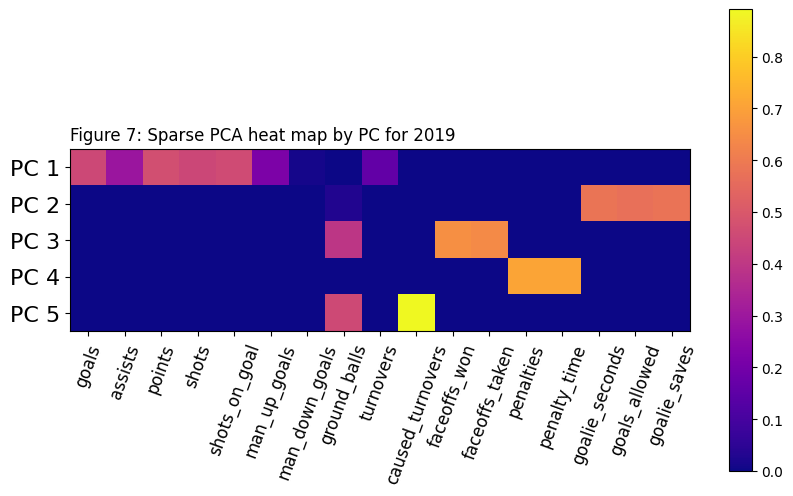

In [28]:
sparse_heat_map(X_norm, best_n_comp, year)

Plot a dendrogram of just the scaled data using the ward model

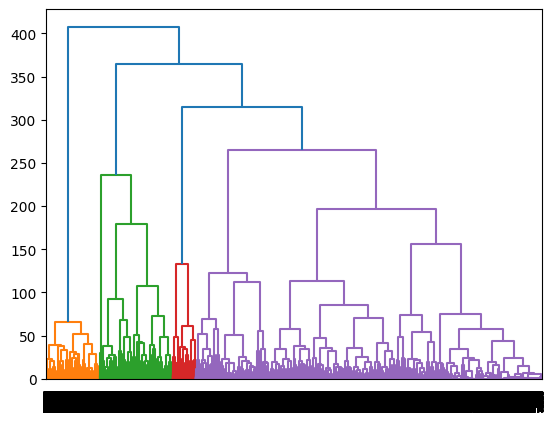

In [17]:
ward_dend = dendrogram(ward(X_norm))

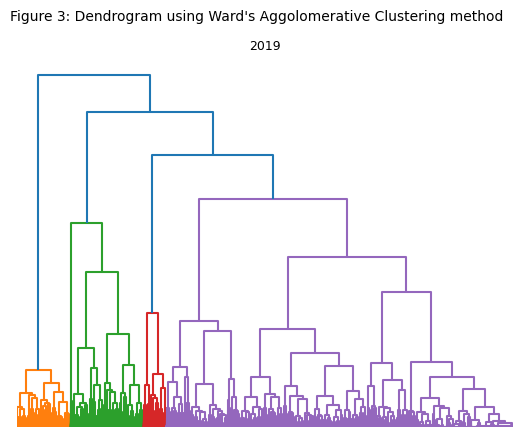

In [29]:
plt.figure()
plt.suptitle("Figure 3: Dendrogram using Ward's Aggolomerative Clustering method", fontsize=10)
plt.title(year, fontsize=9)
#plt.xticks(ticks=None)
plt.axis('off')
ward_dend
plt.show()

What's in the dendrogram? How was X_norm clustered?

In [20]:
ward_dend.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

In [56]:
ward_dend['icoord'][:5], ward_dend['dcoord'][:5], ward_dend['ivl'][:5]

([[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [65.0, 65.0, 75.0, 75.0]],
 [[0.0, 0.5100032081472398, 0.5100032081472398, 0.0],
  [0.0, 0.9973631673336497, 0.9973631673336497, 0.5100032081472398],
  [0.0, 0.540351516838702, 0.540351516838702, 0.0],
  [0.0, 1.0345750510188203, 1.0345750510188203, 0.540351516838702],
  [0.0, 0.5028081705989178, 0.5028081705989178, 0.0]],
 ['17385', '14624', '25206', '23972', '3880'])

In [41]:
np.unique(ward_dend['leaves_color_list']), len(ward_dend['leaves_color_list']), len(X_norm), len(y), len(kmeans_label)

(array(['C1', 'C2', 'C3', 'C4'], dtype='<U2'), 28856, 28856, 28856, 28856)

In [72]:
w_d_df = pd.DataFrame(ward_dend['leaves_color_list'], columns=['dend_assgmt'])
w_d_df['ivl'] = ward_dend['ivl']
w_d_df = w_d_df.astype({'ivl':int})
w_d_df = w_d_df.sort_values('ivl')
w_d_df.head(), w_d_df.dtypes

(      dend_assgmt  ivl
 23224          C4    0
 18594          C4    1
 13741          C4    2
 5991           C2    3
 18081          C4    4,
 dend_assgmt    object
 ivl             int32
 dtype: object)

In [75]:
w_d_df['dend_assgmt'].values

array(['C4', 'C4', 'C4', ..., 'C4', 'C3', 'C4'], dtype=object)

In [42]:
np.unique(kmeans_label), kmeans_label[:10], y[:10]

(array([0, 1, 2, 3, 4, 5, 6]),
 array([5, 5, 3, 0, 5, 0, 5, 5, 3, 5]),
       position
 83284       GK
 83285        M
 83286        M
 83287        A
 83288        M
 83289        A
 83290        D
 83291        D
 83292        A
 83293        D)

In [45]:
pos_df_no = year_df(year)[2]
pos_df_no.shape

(28856, 18)

In [86]:
pos_df_no['kmeans_pred'] = kmeans_label
pos_df_no['dend_assgmt'] = w_d_df['dend_assgmt'].values
pos_df_no.head(15)

,position,goals,assists,points,shots,shots_on_goal,man_up_goals,man_down_goals,ground_balls,turnovers,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,kmeans_pred,dend_assgmt
83284,GK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1800,2,8,5,C4
83285,M,1,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,5,C4
83286,M,2,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,3,C4
83287,A,5,1,6,8,6,0,0,0,0,0,0,0,0,0,0,0,0,0,C2
83288,M,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,5,C4
83289,A,0,5,5,5,1,0,0,1,2,0,0,0,0,0,0,0,0,0,C2
83290,D,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,5,C4
83291,D,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,C4
83292,A,4,0,4,6,5,0,0,4,2,0,0,0,0,0,0,0,0,3,C4
83293,D,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,5,C4


In [87]:
pos_df_no.to_csv('positions_dend')

In [84]:
pos_df_no.groupby(['dend_assgmt','kmeans_pred'])['position'].count()

dend_assgmt  kmeans_pred
C1           2                  6
             3                  1
             4               3145
             5                  9
C2           0               1794
             1               1679
             2                 11
             3                730
             4                  1
             5                 20
             6                  3
C3           0                  1
             1                  1
             2                 85
             3                 10
             5                205
             6               1014
C4           0                248
             1                197
             2               3817
             3               4988
             4                220
             5              10671
Name: position, dtype: int64

In [85]:
pos_df_no.groupby(['dend_assgmt','kmeans_pred','position'])['position'].count().to_csv('dend_groups')